### Outside Data Source: Poloniex

In [6]:
##HEADER

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
matplotlib.rcParams['timezone'] = 'US/Central'

import pickle
import pandas as pd
import numpy as np
import datetime as dt
import itertools as it
import math
import pytz
import sys
import warnings
import os
from IPython.display import display, HTML


import util

from decimal import Decimal
from poloniex import poloniex



cst = pytz.timezone('America/Chicago')

secret = 'd2604c1de9dc757984746e78551936ce53d4f9dd72441e05a5cf61606bd469b6ea41bd1f95a82f08083f220a7e0f89bf018d3f34fa6d9b8e8a7815dace02bd1e'
key    = 'IZQJ94DS-SFJ2D0FW-LK2FUCBX-29FZMFWU'

polo = poloniex(key, secret)

def load_ticker(ticker, start, end, period):
    new_data = pd.DataFrame.from_dict(polo.returnChartData(ticker, start, end, period))
    data = new_data[['volume','weightedAverage']]
    data.index=[dt.datetime.utcfromtimestamp(d) for d in new_data['date']]
    return data


# Create realized volatility index

ticker= 'USDT_BTC'

period = 86400 # time interval at which price is taken (in seconds) i..e 300 = price snapshots every 5 minutes

timeframe= 30 # Number of days (i.e. 7 = Weekly Index)


### Download into daily_data folder

In [7]:
end  =   dt.datetime.utcnow().date()

start = dt.datetime.utcnow().date()-dt.timedelta(days=timeframe*3)


daily_data=pd.DataFrame()
days = pd.date_range(start, end, freq='D')
for d1 in days:
    f_name = '{0} {1}.csv'.format(ticker, str(d1.date()))
    if d1==days[-1]:
        print('\rdownloading: '+f_name, end='', flush=True)
        data = load_ticker(ticker, d1, d1+dt.timedelta(days=1)-dt.timedelta(seconds=period), period)
        data.columns = ['volume',ticker]
        data.to_csv('daily_data/'+ f_name, index_label='time')
#     elif f_name in os.listdir('daily_data/'):
#         print('\rloading: '+f_name, end='', flush=True)
#         data = pd.read_csv('daily_data/'+f_name, parse_dates=True, index_col=0)
    else:
        print('\rdownloading: '+f_name, end='', flush=True)
        data = load_ticker(ticker, d1, d1+dt.timedelta(days=1)-dt.timedelta(seconds=period), period)
        data.columns = ['volume',ticker]
        data.to_csv('daily_data/'+ f_name, index_label='time')
    daily_data=pd.concat([daily_data, data])

downloading: USDT_BTC 2018-08-19.csv

### Realized Index

,volume,USDT_BTC,pct change,log_returns,Volatility,total_volume,timeframe_volume,timeframe_percentage,timeframe_VWAP
2018-07-31,1.233158e+07,7828.400684,-0.031027,-0.031518,0.498406,7.394898e+08,2.721871e+08,0.045306,7127.810595
2018-08-01,1.083774e+07,7561.194584,-0.034133,-0.034729,0.509639,7.394898e+08,2.721871e+08,0.039817,7127.810595
2018-08-02,6.425286e+06,7576.726450,0.002054,0.002052,0.509444,7.394898e+08,2.721871e+08,0.023606,7127.810595
2018-08-03,1.127520e+07,7399.010790,-0.023455,-0.023735,0.518983,7.394898e+08,2.721871e+08,0.041424,7127.810595
2018-08-04,9.226190e+06,7152.888922,-0.033264,-0.033830,0.535192,7.394898e+08,2.721871e+08,0.033896,7127.810595
2018-08-05,4.431720e+06,6987.130278,-0.023174,-0.023446,0.54225,7.394898e+08,2.721871e+08,0.016282,7127.810595
2018-08-06,5.755827e+06,6972.229417,-0.002133,-0.002135,0.541421,7.394898e+08,2.721871e+08,0.021147,7127.810595
2018-08-07,9.018761e+06,6928.977310,-0.006203,-0.006223,0.538807,7.394898e+08,2.721871e+08,0.033134,7127.810595
2018-08-08,1.504136e+07,6420.115197,-0.073440,-0.076276,0.602236,7.394898e+08,2.721871e+08,0.055261,7127.810595
2018-08-09,8.185726e+06,6434.195031,0.002193,0.002191,0.586871,7.394898e+08,2.721871e+08,0.030074,7127.810595


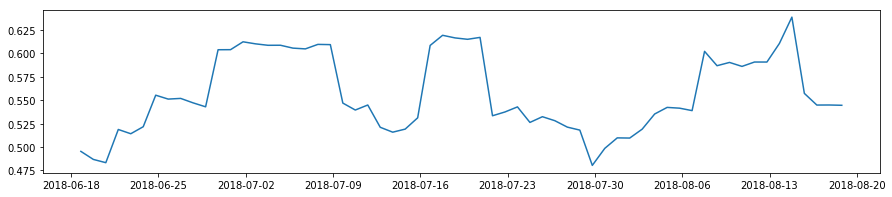

In [15]:
import numpy as np

daily_data['pct change']= daily_data.USDT_BTC.pct_change()
daily_data['log_returns']=np.log(daily_data.USDT_BTC) - np.log(daily_data.USDT_BTC.shift(1))


daily_data['Volatility']=''

for i,k in zip(range(len(daily_data)),daily_data.index):
    daily_data.loc[k,('Volatility')]= daily_data.iloc[i-(timeframe-1):i+1].log_returns.std()*math.sqrt(365)
    
daily_data['total_volume']=daily_data['volume'].sum()
    
    
display(HTML(daily_data[-20:].to_html()))

daily_data['timeframe_volume']=daily_data['volume'].iloc[i-(timeframe-1):i+1].sum()

for i,k in zip(range(len(daily_data)),daily_data.index):
    daily_data['timeframe_percentage']= (daily_data.iloc[i-(timeframe-1):i+1].volume/daily_data.iloc[i-(timeframe-1):i+1].timeframe_volume)
    
daily_data['timeframe_VWAP']= (daily_data['USDT_BTC']*daily_data['timeframe_percentage']).sum()
    
daily_data[-31:]

util.quick_plot(daily_data['Volatility'][:])